# Optimization Project 2 - Integer Programming

### Team Members:

**Ambikha Maharaj** 

**Anant Gupta - ag78593**

**Dipali Pandey**

**Nir Rauch**

### Section 0 - Library and Data Imports 

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
import matplotlib.pyplot as plt

#### Change time_limit and CSV Inputs in Following Cell

**Assumptions** - First column of CSV is date and second column is index

In [63]:
time_limit = 3600

df_2019 = pd.read_csv('stocks2019.csv')
df_2020 = pd.read_csv('stocks2020.csv')

df_2019.iloc[:,0] = pd.to_datetime(df_2019.iloc[:,0])
df_2020.iloc[:,0] = pd.to_datetime(df_2020.iloc[:,0])

df_2019.rename(columns={df_2019.columns[0]: 'Date'}, inplace = True)
df_2020.rename(columns={df_2020.columns[0]: 'Date'}, inplace = True)

df_2019.set_index('Date', inplace=True)
df_2020.set_index('Date', inplace=True)

### Section 1 - Defining helper functions

#### Function to Get Returns

In [3]:
def get_returns(df):

    shift_df = df.shift(1)
    return_df = (df - shift_df)/shift_df
    return_df.dropna(inplace=True)
    
    return return_df

#### Function to Optimize Objective Using Gurobi

In [4]:
def optimizer(obj, A, b, sense, rule, vtype = None, ub = None, lb = None):
    
    GPModel = gp.Model()
    GPModX = GPModel.addMVar(len(obj), vtype = vtype, ub = ub, lb = lb) 
    GPModCon = GPModel.addMConstr(A, GPModX, sense, b)
    
    if rule == 'Max':
        GPModel.setMObjective(None, obj, 0, sense = gp.GRB.MAXIMIZE)
    else:
        GPModel.setMObjective(None, obj, 0, sense = gp.GRB.MINIMIZE)  
        
    GPModel.Params.OutputFlag = 0
    GPModel.Params.TimeLimit = time_limit
    GPModel.optimize()
    return GPModel.objVal, GPModX.x

#### Function to select stocks based on correlation matrix

In [5]:
def stock_select(m, p, df):

    # Total Number of Stocks
    n = len(p)

    obj = np.zeros(n*n + n)
    obj[:n*n] = np.ravel(p.to_numpy())
    A = np.zeros((n**2 + n + 1, n**2 + n))
    b = np.zeros(n**2 + n + 1)
    sense = np.array([''] * (n**2 + n + 1))

    # Constraint 1
    A[0, n*n:] = 1
    b[0] = m
    sense[0] = '='

    # Constraint 2
    for i in range(1, n+1):
        for j in range((i-1)*n, (i-1)*n + n):
            A[i,j] = 1
        b[i] = 1
        sense[i] = '='

    # Constraint 3
    row = i + 1
    for i in range(0, n):
        for j in range(0, n):
            A[row, i*n + j] = 1
            A[row, n*n + j] = -1
            b[row] = 0
            sense[row] = '<'
            row += 1

    #Variable type
    vtype = ['B'] * len(obj)
    
    #Calling optimization function
    obj, x = optimizer(obj, A, b, sense, 'Max', vtype)
    
    stocks = x[n*n:]
    stock_indexes = np.where(stocks == 1)[0].tolist()
    
    r = df.iloc[:,1:]
    stock_names = r.iloc[:,stock_indexes].columns.tolist()
    
    return stock_indexes, stock_names

#### Function to Calculate Portfolio Weights

$$ \underset{w}min \sum_{t=1}^T y_t $$
$$ s.t. \sum_{i=1}^m w_i = 1 $$
$$ y_t + \sum_{i=1}^m w_i r_{it} \geq q_t \; for \; t = 1,2,...,T $$
$$ y_t - \sum_{i=1}^m w_i r_{it} \geq -q_t \; for \; t = 1,2,...,T $$
$$ w_i \geq 0 $$

In [6]:
def portfolio_weights(m, df, stock_names):

    q = df.iloc[:, 0].values
    stocks_2019 = df.iloc[:, 1:]
    r = stocks_2019.loc[:, stock_names].values

    # Total Number of Dates
    T = len(r)

    obj = np.zeros(T + m)
    obj[:T] = 1
    A = np.zeros((2*T + 1, T + m))
    b = np.zeros(2*T + 1)
    sense = np.array([''] * (2*T + 1))
    
    # Constraint 1
    A[0, -m:] = 1
    b[0] = 1
    sense[0] = '='
    
    # Constraint 2
    for t in range(1, T+1):
        # setting coefficient for y_t
        A[t, t - 1] = 1
        A[t + T, t - 1] = 1

        # setting coefficient of index return
        A[t, -m:] = r[t - 1, :]
        A[t + T, -m:] = -r[t - 1, :]

        # setting b
        b[t] = q[t - 1]
        b[t + T] = -q[t - 1]

        # setting direction
        sense[t] = '>'
        sense[t + T] = '>'
    
    obj, x = optimizer(obj, A, b, sense, 'Min')
    stock_weights = x[-m:]

    return stock_weights

#### Function to Calculate Portfolio Weights Directly (Without Stock Selection)

$$ \underset{w}min \sum_{t=1}^T y_t $$
$$ s.t. \sum_{i=1}^n w_i = 1 $$
$$ \sum_{i=1}^n y_i = m $$
$$ w_i - My_i \leq 0 \; for \; i = 1,2,...,n $$
$$ y_t + \sum_{i=1}^n w_i r_{it} \geq q_t \; for \; t = 1,2,...,T $$
$$ y_t - \sum_{i=1}^n w_i r_{it} \geq -q_t \; for \; t = 1,2,...,T $$
$$ w_i \geq 0 $$

In [7]:
def portfolio_weights_direct(m, df):
    
    q = df.iloc[:, 0].values
    r = df.iloc[:, 1:].values

    # Total Number of Dates
    T = r.shape[0]

    # Total Number of Stocks
    n = r.shape[1]
    M = 1

    obj = np.zeros(n*2 + T)
    obj[(n*2):] = 1
    A = np.zeros((2*T + n + 2, n*2 + T))
    b = np.zeros(2*T + n + 2)
    sense = np.array([''] * (2*T + n + 2))

    # Constraint 1
    A[0, :n] = 1
    b[0] = 1
    sense[0] = '='

    # Constraint 2
    A[1, n:(n*2)] = 1
    b[1] = m
    sense[1] = '='

    # Constraint 3 - Big M Constraint
    for i in range(2, n+2):
        A[i,[i-2,i-2+n]] = [1,-M]    
        b[i] = 0
        sense[i] = '<'

    # Constraint 4
    for t in range(n+2, n+2+T):
        A[t, 0:n] = r[t-n-2,:]
        A[t, n+t-2] = 1
        b[t] = q[t-n-2]
        sense[t] = '>'

        A[t+T, 0:n] = [i * (-1) for i in r[t-n-2,:]]
        A[t+T, n+t-2] = 1
        b[t+T] = (-1) * q[t-n-2]
        sense[t+T] = '>'

    vtype = ['C']*n + ['B']*n + ['C']*T

    obj, x = optimizer(obj, A, b, sense, 'Min', vtype)
    
    stock_weights = x[:n]
    stock_weights = stock_weights[stock_weights>0]
    stock_indexes = np.where(stock_weights > 0)[0].tolist()
    
    r = df.iloc[:, 1:]
    stock_names = r.iloc[:,stock_indexes].columns.tolist()
    
    return stock_weights, stock_indexes, stock_names

#### Function to Measure Portfolio Performance Score

In [37]:
def get_performance_score(index_return, stocks_return, stock_weights):
    
    index_return = np.ravel(index_return)
    portfolio_return = (stocks_return @ stock_weights)
    portfolio_return = np.ravel(portfolio_return)
    
    # Difference in returns
    diff = index_return - portfolio_return
    
    # Calculating Score
    score = np.sum(np.abs(diff))
    
    return score, portfolio_return

#### Function to Graph Index vs Portfolio Performance

In [14]:
def portfolio_perf(index, portfolio, date):
    
    plt.figure(figsize=(20, 8))
    plt.plot(date, index*100, label='Index Percentage Returns', color='red')
    plt.plot(date, portfolio*100, label='Portfolio Percentage Returns', color='blue')
    
    plt.legend()
    plt.title('Index vs Portfolio')
    plt.xlabel('Date')
    plt.ylabel('Percentage Returns')
    
    plt.show()

### Section 2 - Main Code

In [64]:
# Calculating returns and correlation matrix for 2019
returns_2019 = get_returns(df_2019)
p_2019 = returns_2019.iloc[:, 1:].corr()
stocks_2019 = returns_2019.iloc[:, 1:]
index_2019 = returns_2019.iloc[:,0].to_frame()


# Calculating returns and correlation matrix for 2020
returns_2020 = get_returns(df_2020)
p_2020 = returns_2020.iloc[:, 1:].corr()
stocks_2020 = returns_2020.iloc[:, 1:]
index_2020 = returns_2020.iloc[:,0].to_frame()


# Number of stocks in the read csv
m = stocks_2019.shape[1]


# List of desired stocks in the portfolio
if(m>10):
    m_list = [5] + list(np.arange(10,m+1,10))
elif(5<=m<=10):
    m_list = [5, m]
else:
    m_list = [m]

    
# Create DataFrame of Performances for each Value of m
df_indirect_per = pd.DataFrame(columns = ['#Stocks', 'Insample Score - Indirect', 'Outsample Score - Indirect'])
df_direct_per = pd.DataFrame(columns = ['#Stocks', 'Insample Score - Direct', 'Outsample Score - Direct'])

In [10]:
# Calculate Portfolio Performances using the Indirect Method
for m in m_list:
    print('Optimizing for best',m, 'stocks')
    stock_indexes, stock_names = stock_select(m, p_2019, returns_2019)
    stock_weights = portfolio_weights(m, returns_2019, stock_names)
    insample_per, portfolio_return_in = get_performance_score(index_2019.values, stocks_2019.values[:, stock_indexes], stock_weights)
    outsample_per, portfolio_return_out = get_performance_score(index_2020.values, stocks_2020.values[:, stock_indexes], stock_weights)
    df_indirect_per.loc[len(df_indirect_per)] = [m, insample_per, outsample_per]

Optimizing for best 5 stocks
Academic license - for non-commercial use only - expires 2022-08-21
Using license file C:\Users\anant\gurobi.lic
Optimizing for best 10 stocks
Optimizing for best 20 stocks
Optimizing for best 30 stocks
Optimizing for best 40 stocks
Optimizing for best 50 stocks
Optimizing for best 60 stocks
Optimizing for best 70 stocks
Optimizing for best 80 stocks
Optimizing for best 90 stocks
Optimizing for best 100 stocks


In [11]:
# Calculate Portfolio Performances using the Direct Method
for m in m_list:
    print('Optimizing for best',m, 'stocks')
    stock_weights, stock_indexes, stock_names = portfolio_weights_direct(m, returns_2019)
    insample_per, portfolio_return_in = get_performance_score(index_2019.values, stocks_2019.values[:, stock_indexes], stock_weights)
    outsample_per, portfolio_return_out = get_performance_score(index_2020.values, stocks_2020.values[:, stock_indexes], stock_weights)
    df_direct_per.loc[len(df_direct_per)] = [m, insample_per, outsample_per]

Optimizing for best 5 stocks
Optimizing for best 10 stocks
Optimizing for best 20 stocks
Optimizing for best 30 stocks
Optimizing for best 40 stocks
Optimizing for best 50 stocks
Optimizing for best 60 stocks
Optimizing for best 70 stocks
Optimizing for best 80 stocks
Optimizing for best 90 stocks
Optimizing for best 100 stocks


In [12]:
# Merging results for insample and outsample performance
final_df = df_direct_per.merge(df_indirect_per, left_on = '#Stocks', right_on = '#Stocks')
final_df

,#Stocks,Insample Score - Direct,Outsample Score - Direct,Insample Score - Indirect,Outsample Score - Indirect
0,5.0,2.092690,1.957495,0.789178,1.112437
1,10.0,1.119308,1.101784,0.686533,1.097709
2,20.0,0.968096,1.132005,0.473736,0.940289
3,30.0,0.811208,1.060096,0.418015,0.769110
4,40.0,0.721295,1.213765,0.367439,0.788335
5,50.0,0.964629,1.419954,0.334010,0.773216
6,60.0,0.795849,1.664745,0.343788,1.166438
7,70.0,0.860009,1.343601,0.168587,0.545744
8,80.0,0.680133,1.286971,0.147683,0.537323
9,90.0,0.681677,1.196596,0.053779,0.367790


#### Analysis and Visualizations

##### Index vs Portfolio - Insample (m=5)

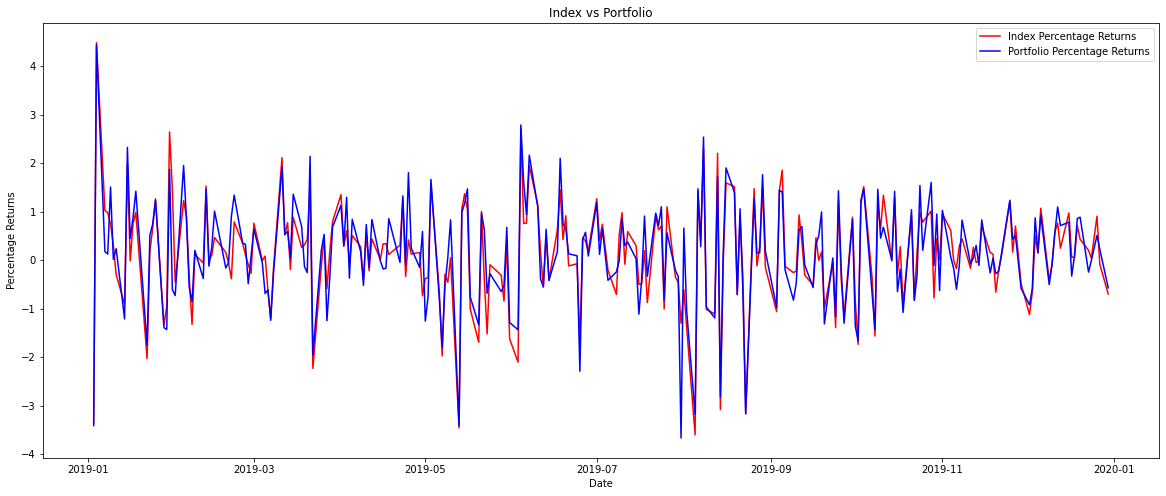

In [55]:
stock_indexes, stock_names = stock_select(5, p_2019, returns_2019)
stock_weights = portfolio_weights(5, returns_2019, stock_names)
insample_per, portfolio_return_in = get_performance_score(index_2019.values, stocks_2019.values[:, stock_indexes], stock_weights)
portfolio_perf(index_2019.values, portfolio_return_in, stocks_2019.index.values)

##### Index vs Portfolio - Outsample (m=5)

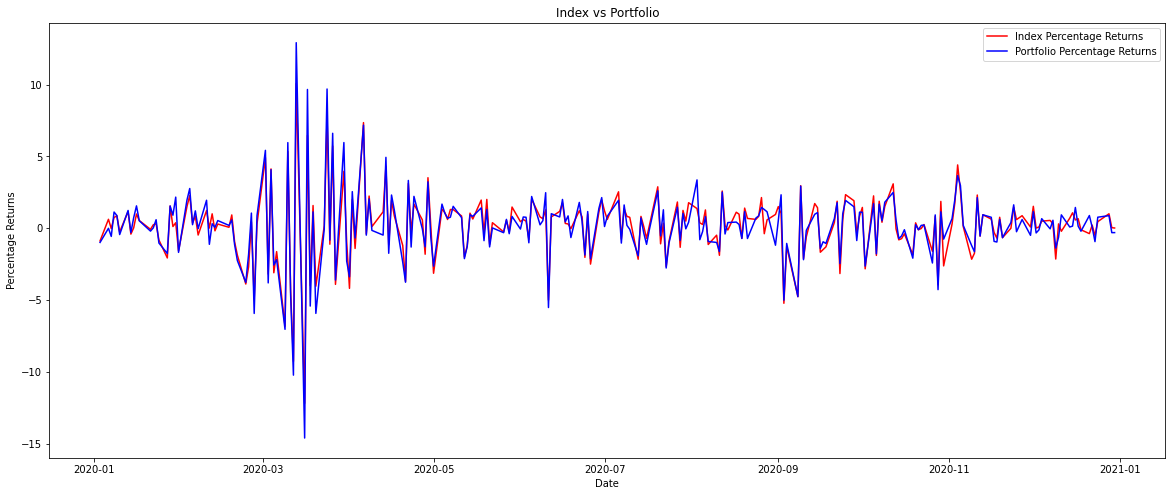

In [66]:
stock_indexes, stock_names = stock_select(5, p_2020, returns_2020)
stock_weights = portfolio_weights(5, returns_2020, stock_names)
outsample_per, portfolio_return_out = get_performance_score(index_2020.values, stocks_2020.values[:, stock_indexes], stock_weights)
portfolio_perf(index_2020.values, portfolio_return_out, stocks_2020.index.values)

##### Performance vs. Number of Stocks

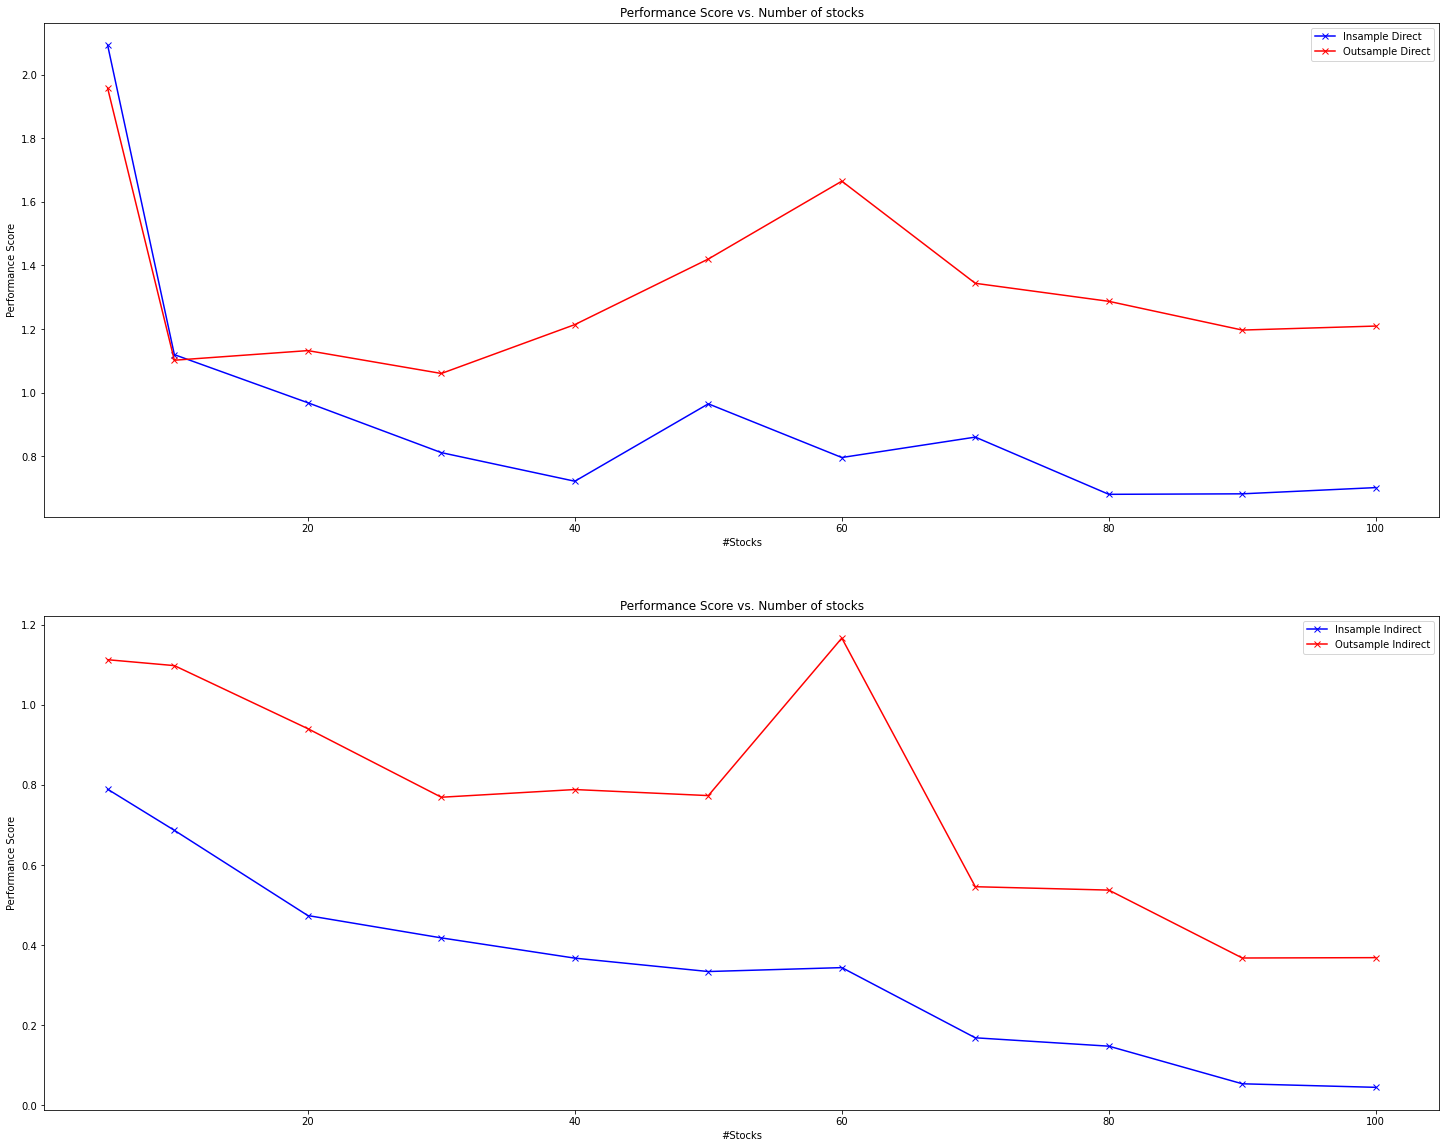

In [13]:
fig, (ax1, ax2) = plt.subplots(figsize = (25, 20), nrows= 2, ncols=1)

ax1.plot(final_df['#Stocks'], final_df['Insample Score - Direct'], color='blue', marker = 'x', label='Insample Direct')
ax1.plot(final_df['#Stocks'], final_df['Outsample Score - Direct'], color='red', marker = 'x', label='Outsample Direct')
ax1.legend()
ax1.set_xlabel('#Stocks')
ax1.set_ylabel('Performance Score')
ax1.set_title('Performance Score vs. Number of stocks')

ax2.plot(final_df['#Stocks'], final_df['Insample Score - Indirect'], color='blue', marker = 'x', label='Insample Indirect')
ax2.plot(final_df['#Stocks'], final_df['Outsample Score - Indirect'], color='red', marker = 'x', label='Outsample Indirect')
ax2.legend()
ax2.set_xlabel('#Stocks')
ax2.set_ylabel('Performance Score')
ax2.set_title('Performance Score vs. Number of stocks')
plt.show()